In [1]:
import numpy as np
import scipy as sp
import time as ti
import fidi as fi

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation as ani

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

from scipy import sparse
from scipy.sparse.linalg import eigsh
from IPython.display import display, HTML, Image
from tqdm.notebook import tqdm

matplotlib.rcParams['animation.embed_limit'] = 7*2**23
%matplotlib notebook

pi = np.pi

# Quantum Simulator

## Introduction

In this notebook, we will build a 1-D quantum wave function simulator using finite difference approximation method. Schrodinger's equation will be solved via the discretization of spatial derivative. First of all, let us setup the discretization scheme. The region of space for the simulation must be of finite length and either bounded or periodic.

### Setup

In [2]:
X = 10 # Spatial domain ranges from -X to X
nP = 4096 # number of points on the grid
nU = nP - 2 # number of unknowns (endpoints are excluded)
dX = 2*X/(nP-1) # spacing between adjacent points
x = fi.spacing(-X, X, nU, bound=False)

In [3]:
%%time
# finite difference approximation for 1st derivative
df = (1/dX)*fi.diff(nU, 20, d='First', bc='Bounded')
# finite difference approximation for 2nd derivative
ddf = (1/dX**2)*fi.diff(nU, 20, d='Second', bc='Bounded')

Generating bounded difference matrix...


  0%|          | 0/4094 [00:00<?, ?it/s]

Generating bounded difference matrix...


  0%|          | 0/4094 [00:00<?, ?it/s]

CPU times: total: 5min 16s
Wall time: 5min 17s


### Useful functions

In [4]:
def hconj(matrix): # hermitian conjugate of matrix
    return matrix.conj().transpose()
def inner(psi1, psi2): # inner product
    return np.inner(psi1.conj(), psi2)
def outer(psi1, psi2): # 
    return np.outer(psi1.conj(), psi2)
def norm(psi):
    return inner(psi, psi)**(-1/2)
def normal(psi):
    return psi/norm(psi)
def sandwich(operator, psi1, psi2):
    return inner(psi1, operator.dot(psi2))

### Hamiltonian

In [5]:
potential = 1/2*np.diag(x**2)
kinetic = -1/2*ddf
hamiltonian = sparse.coo_array(kinetic + potential)

### Solve eigensystem

In [6]:
n_ei = 20
tol_ei = 0.0001

In [7]:
%%time
eigenvalues, eigenstates = eigsh(hamiltonian, k=n_ei, tol=tol_ei, which='SA')

29.692580461502075

In [8]:
# Dephase eigenstates
eigenstates = np.real(eigenstates)

amplitude = np.zeros(n_ei)
for i in range(n_ei):
    amplitude[i] = np.real(inner(eigenstates[:,i], eigenstates[:,i]))**(1/2)

eigenstates = eigenstates@np.diag(1/amplitude)

In [9]:
# diag = eigenstates.T@hamiltonian@eigenstates+1e-20

# plt.figure()
# plt.imshow(np.log10(np.abs(diag)))
# plt.colorbar()
# plt.show()

### Plot eigenstates

<IPython.core.display.Javascript object>


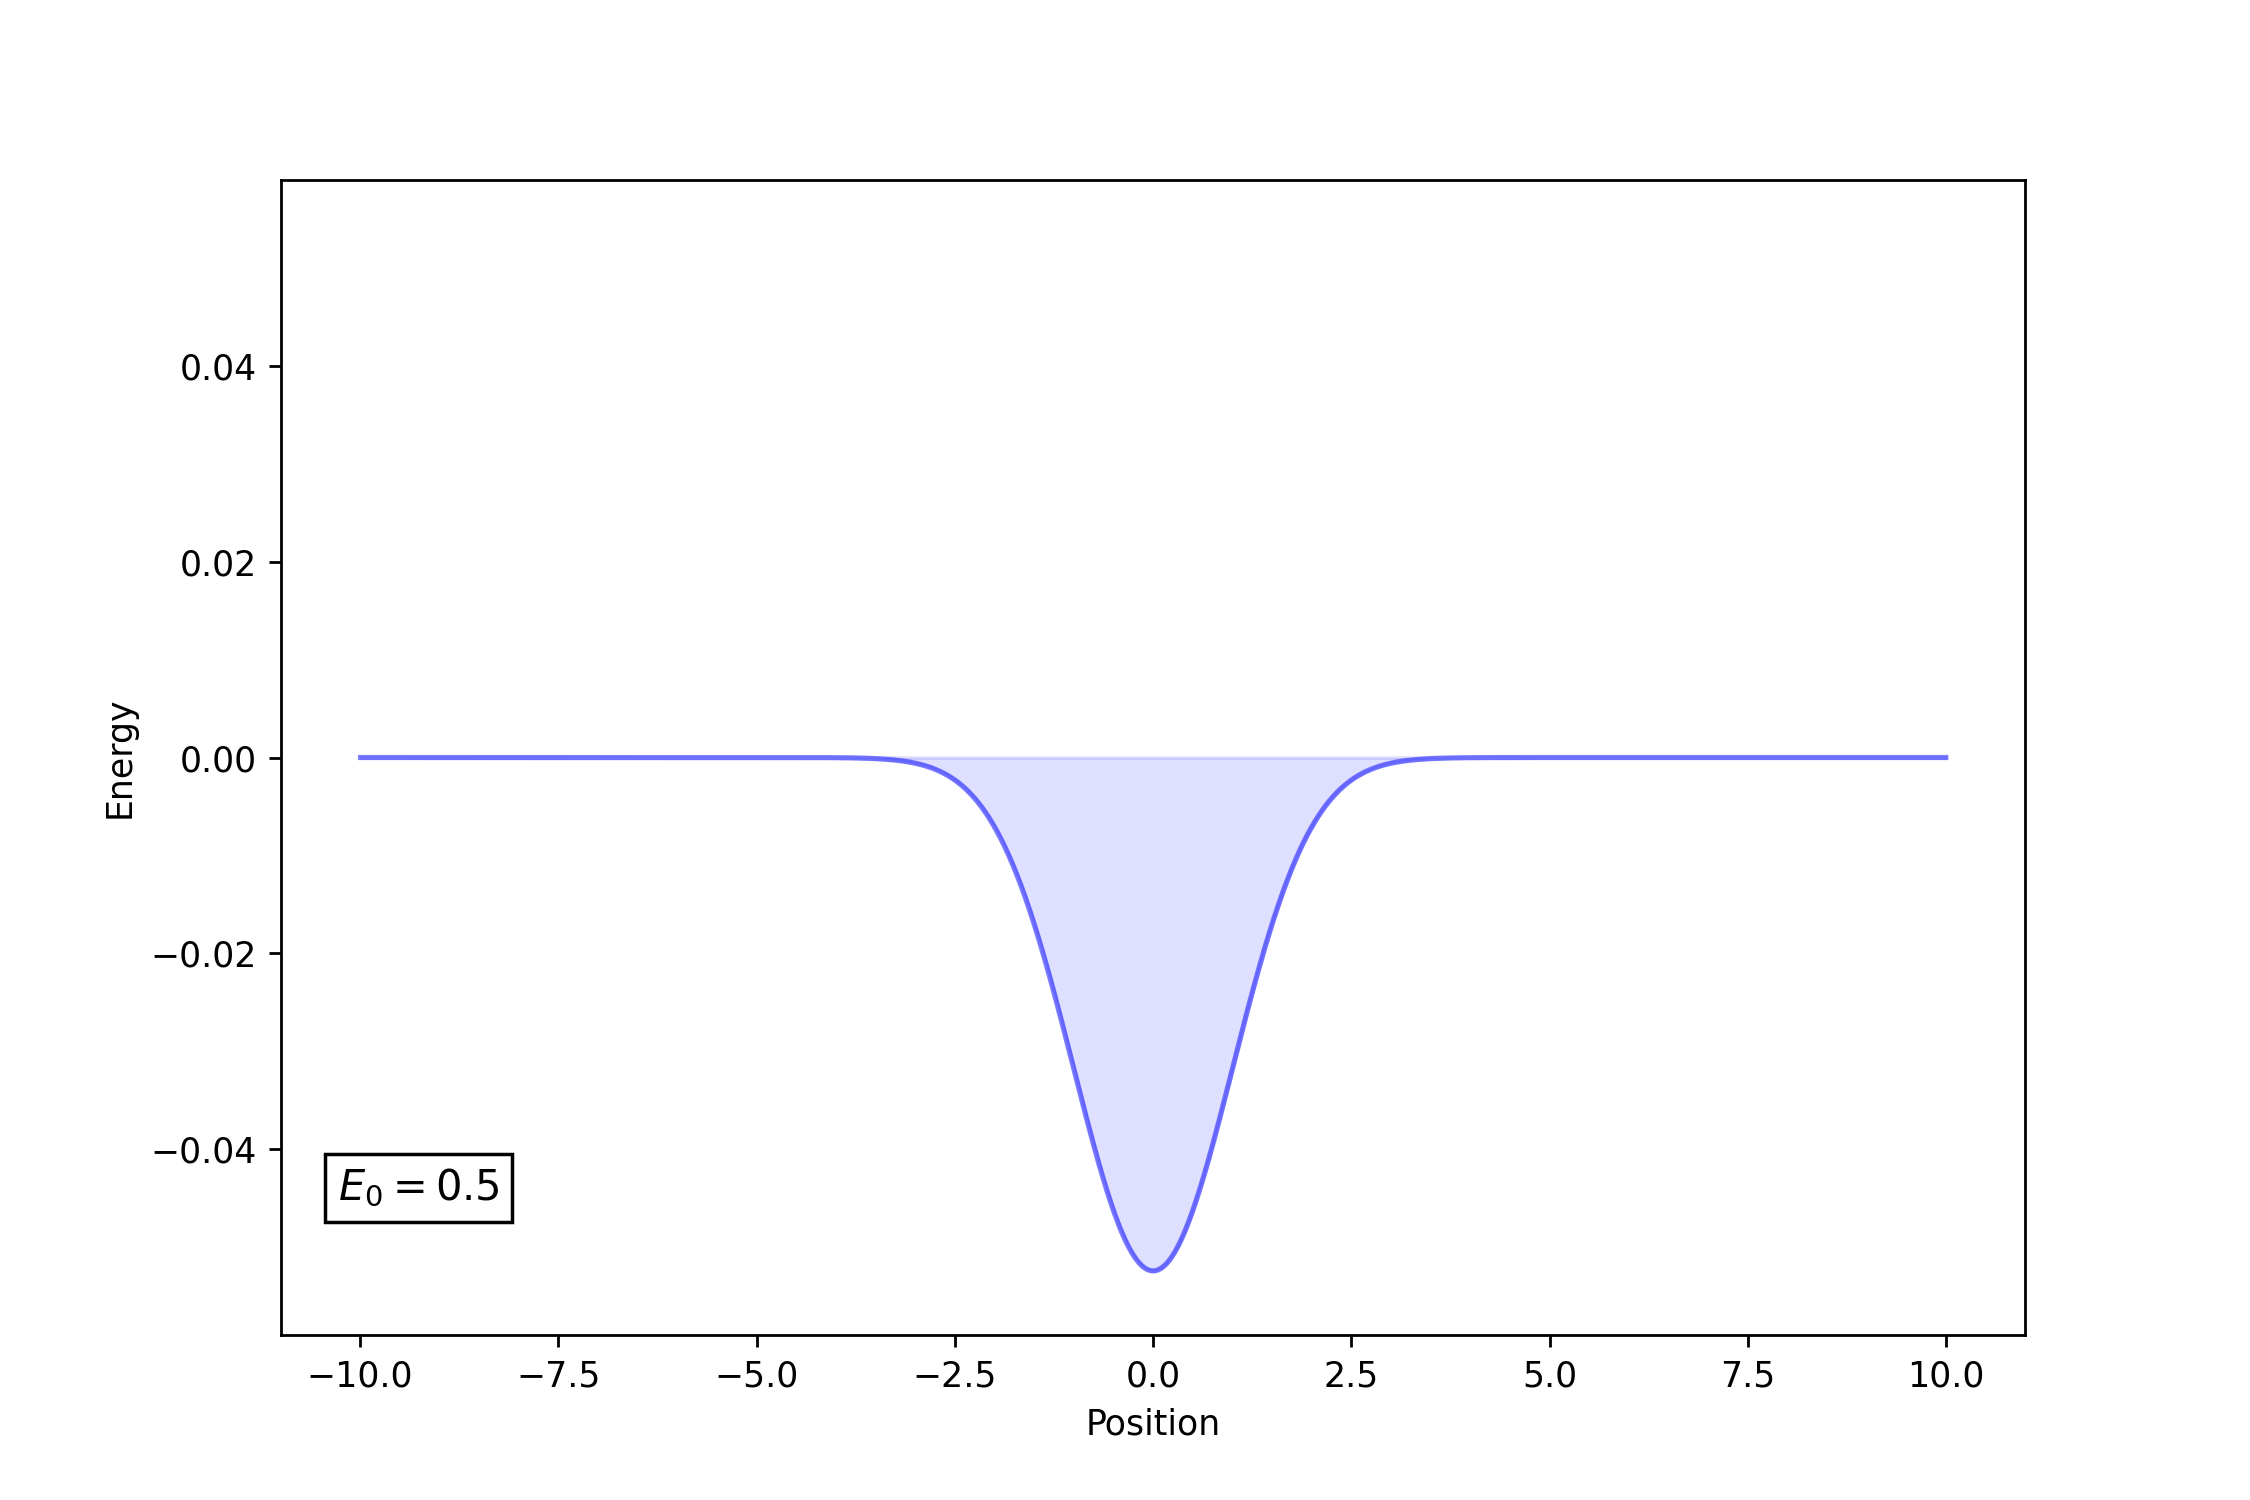

interactive(children=(IntSlider(value=0, description='state', max=19), Output()), _dom_classes=('widget-intera…

In [10]:
fig0 = plt.figure(figsize=(9,6))
ax0 = fig0.add_subplot(1, 1, 1)

ylimit0 = 1.125*np.abs(eigenstates).max()
yrange0 = plt.ylim(-ylimit0, ylimit0)

ax0.set_ylabel(r'Energy')
ax0.set_xlabel(r'Position')

line0, = ax0.plot(x, eigenstates[:,0], color='b', alpha=0.5)
linefill0 = ax0.fill_between(x, eigenstates[:,0], color='b', alpha=0.125)

energy_texts = (r'$E_{1} = $' + str(format(eigenvalues[0], '.3g')))
energy_textbox = fig0.text(0.15, 0.20, energy_texts, color='k', fontsize=12, bbox=dict(boxstyle='square, pad=0.3', ec='k', fc='w'))

@widgets.interact(state=(0, n_ei-1, 1))
def update(state=0):
    energy_textbox.set_text(r'$E_{' + str(state) + '} = $' + str(format(eigenvalues[state], '.3g')))
    line0.set_ydata(eigenstates[:, state])
    dummy = ax0.fill_between(x, eigenstates[:, state], color='b', alpha=0.125)
    verts = dummy.get_paths()[0]
    dummy.remove()
    linefill0.set_paths([verts.vertices])
    fig0.canvas.draw_idle()